# Задача
[Соревнование](https://www.kaggle.com/competitions/sberbank-russian-housing-market/overview)

Данные предоставлены Сбербанком, старейшим и крупнейшим банком России. Прогнозирование стоимости недвижимости является критически важной задачей для клиентов банка — арендаторов, застройщиков и кредиторов. Точный прогноз позволяет лучше планировать бюджеты и снижать риски. Сбербанк проводит это соревнование, чтобы привлечь сообщество специалистов по машинному обучению и данным для разработки наиболее точных моделей, способных учесть сложные взаимосвязи между характеристиками жилья и макроэкономическими факторами.

Полный список сущностей данных с описаниями:
- full_sq - общая площадь
- life_sq - жилая площадь
- floor - этаж квартиры
- max_floor - максимальный этаж в здании
- material - материал стен
- build_year - год постройки
- num_room - количество комнат
- kitch_sq - площадь кухни


# TODO

**Инфраструктура и локация:**
- Многочисленные признаки, описывающие инфраструктуру в радиусе от объекта (например, `cafe_count_5000`, `sport_count_5000`, `market_count_5000` и другие)

- `timestamp` - дата сделки
- В основной набор данных также включены агрегированные макроэкономические показатели (такие как индекс потребительских цен, курс доллара, цены на нефть и др.), привязанные к дате сделки

**Целевая переменная:**
- `price_doc` - цена сделки в рублях (только в обучающем наборе)

Дополнительные макроэкономические данные, предоставленные в отдельном файле, могут быть использованы для обогащения основной таблицы и построения более сложных временных признаков.


In [ ]:
import os
import time
import re

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

import torch
import matplotlib.pyplot as plt
import seaborn as sns

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [52]:
def remove_outline(df: pd.DataFrame, cols: list, low_coef: float=0.01, high_coef:float=0.99):
    
    df = df.copy()
    
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        q_low = df[col].quantile(low_coef)
        q_high = df[col].quantile(high_coef)
        df[col] = df[col].clip(lower=q_low, upper=q_high)
        
    return df


def visualize_distributions(df: pd.DataFrame, cols: list, bins: int = 30, log_scale: bool = False):
    """
    Визуализация распределений колонок.
    Для каждой строки строится два графика (по два признака на строку).
    """
    
    df = df.copy()

    n_cols, n_features = 2, len(cols)
    n_rows = int(np.ceil(n_features / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
    
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    for i, col in enumerate(cols):
        series = pd.to_numeric(df[col])
        ax = axes[i]
        
        if log_scale:
            ax.set_xscale('log')
        
        ax.hist(series, bins=bins, alpha=0.8)
        ax.set_title(f"Распределение {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Плотность")
        ax.grid(alpha=0.3)
    
    for j in range(len(cols), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [53]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
macro_data = pd.read_csv('./data/macro.csv')

train_data = pd.merge(train_data, macro_data, how="left", on="timestamp")
test_data = pd.merge(test_data, macro_data, how="left", on="timestamp")

Избавимся от фичей, у которых 50% данных составляют Nan

In [54]:
# nan_ratio = train_data.isna().mean()
# cols_to_drop = nan_ratio[nan_ratio >= 0.5].index.tolist()
# train_data.drop(columns=cols_to_drop, inplace=True)

Избавляемся от фичей, у котроые коррелируют с price_doc след. образом:
```feature < 0.09```

In [55]:
# nan_ratio = train_data.isna().mean()
# cols_to_drop = nan_ratio[nan_ratio >= 0.5].index.tolist()
# train_data.drop(columns=cols_to_drop, inplace=True)



# numeric_cols = train_data.select_dtypes(include=[np.number]).columns
# corr = train_data[numeric_cols].corr()['price_doc']
# to_drop = corr[abs(corr) < 0.09].index
# to_drop = [col for col in to_drop if col != 'price_doc']
# train_data_filtered = train_data.drop(columns=to_drop)
# train_data_filtered.shape

In [56]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)        
pd.set_option('display.max_colwidth', 50)   
pd.set_option('display.precision', 3)  


display(HTML("<h3>TRAIN DATA (первые 5 строк)</h3>"))
display(train_data.head())

display(HTML("<h3>TEST DATA (первые 5 строк)</h3>"))
display(test_data.head())

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

### EDA

Проведем анализ признаков: 
- определим количество фичей с типом данных object и выполним их преобразование в соответствующие типы данных
- рассчитаем количество пропущенных значений для каждого признака
- обработаем каждую фичу с опред. глубиной гранулярности (зависит от важности фичи)

In [57]:
print(train_data.dtypes)
print("\nРаспределение типов данных:")
print(train_data.dtypes.value_counts())

id                               int64
timestamp                       object
full_sq                          int64
life_sq                        float64
floor                          float64
                                ...   
bandwidth_sports               float64
population_reg_sports_share    float64
students_reg_sports_share      float64
apartment_build                float64
apartment_fund_sqm             float64
Length: 391, dtype: object

Распределение типов данных:
float64    213
int64      159
object      19
Name: count, dtype: int64


In [58]:
object_columns = train_data.select_dtypes(include=['object']).columns.tolist()
train_data[object_columns].sample(4)

,timestamp,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology,child_on_acc_pre_school,modern_education_share,old_education_build_share
3766,2012-09-21,OwnerOccupier,Poselenie Vnukovskoe,no,no,no,no,no,no,no,no,no,yes,no,no,no data,"7,311",NaN,NaN
129,2011-10-15,Investment,Lefortovo,no,no,no,no,yes,no,no,no,yes,no,no,no,poor,#!,NaN,NaN
14167,2014-01-27,Investment,Gol'janovo,no,no,no,no,yes,no,no,no,no,no,no,no,good,"16,765","93,08","25,47"
16386,2014-03-22,Investment,Nizhegorodskoe,no,yes,no,no,yes,no,no,no,no,no,no,yes,poor,"16,765","93,08","25,47"


Преобразуем timestamp в datetime для удобства работы с датами и временем

In [59]:
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])

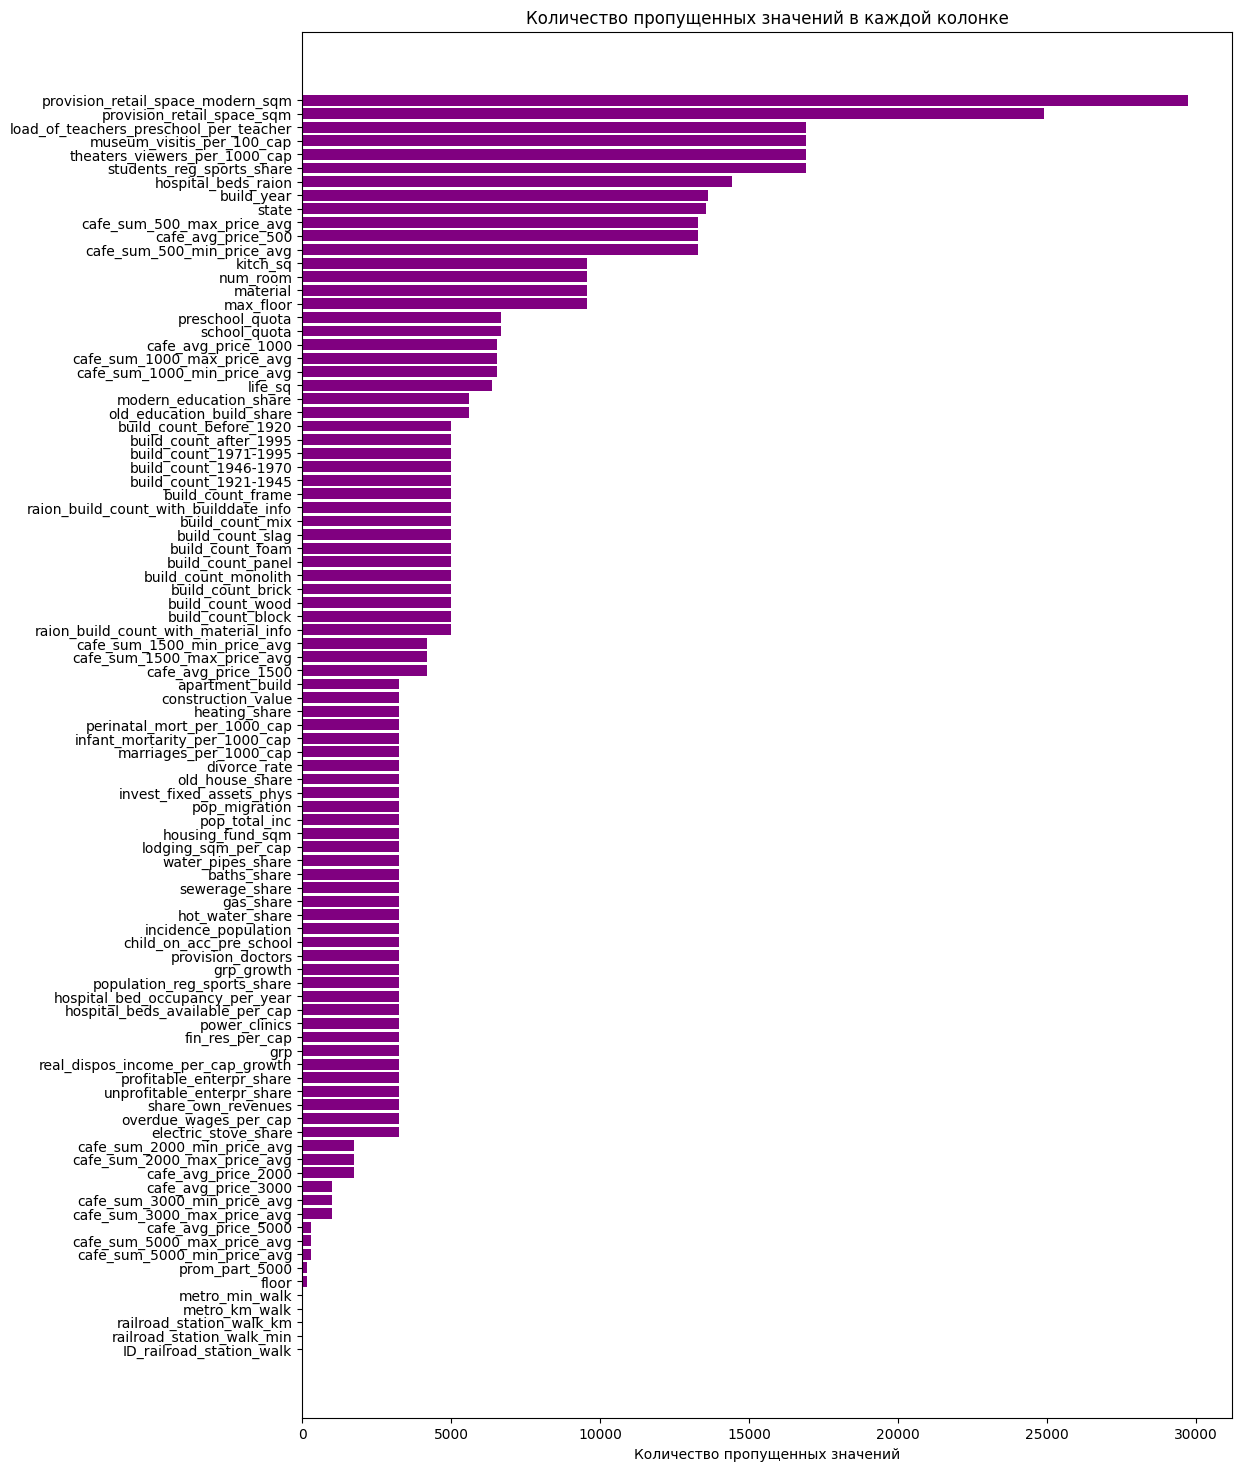

In [60]:
missing_data = train_data.isnull().sum(axis=0).reset_index()
missing_data.columns = ['column_name', 'missing_count']
missing_data = missing_data.loc[(missing_data['missing_count'] > 0), :]
missing_data = missing_data.sort_values(by='missing_count')
ind = range(missing_data.shape[0])

fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_data['missing_count'], color="purple")
ax.set_yticks(ind)
ax.set_yticklabels(missing_data.column_name.values, rotation='horizontal')
ax.set_xlabel("Количество пропущенных значений")
ax.set_title("Количество пропущенных значений в каждой колонке")
plt.show()

Поскольку в данных есть пропущенные значения, то нужно их обработать, но предварительно оценим как **null-count** (пропущенные значения) зависят от цены сделки (price_doc).

In [61]:
train_data['null_count'] = train_data.isnull().sum(axis=1)
test_data['null_count'] = test_data.isnull().sum(axis=1)

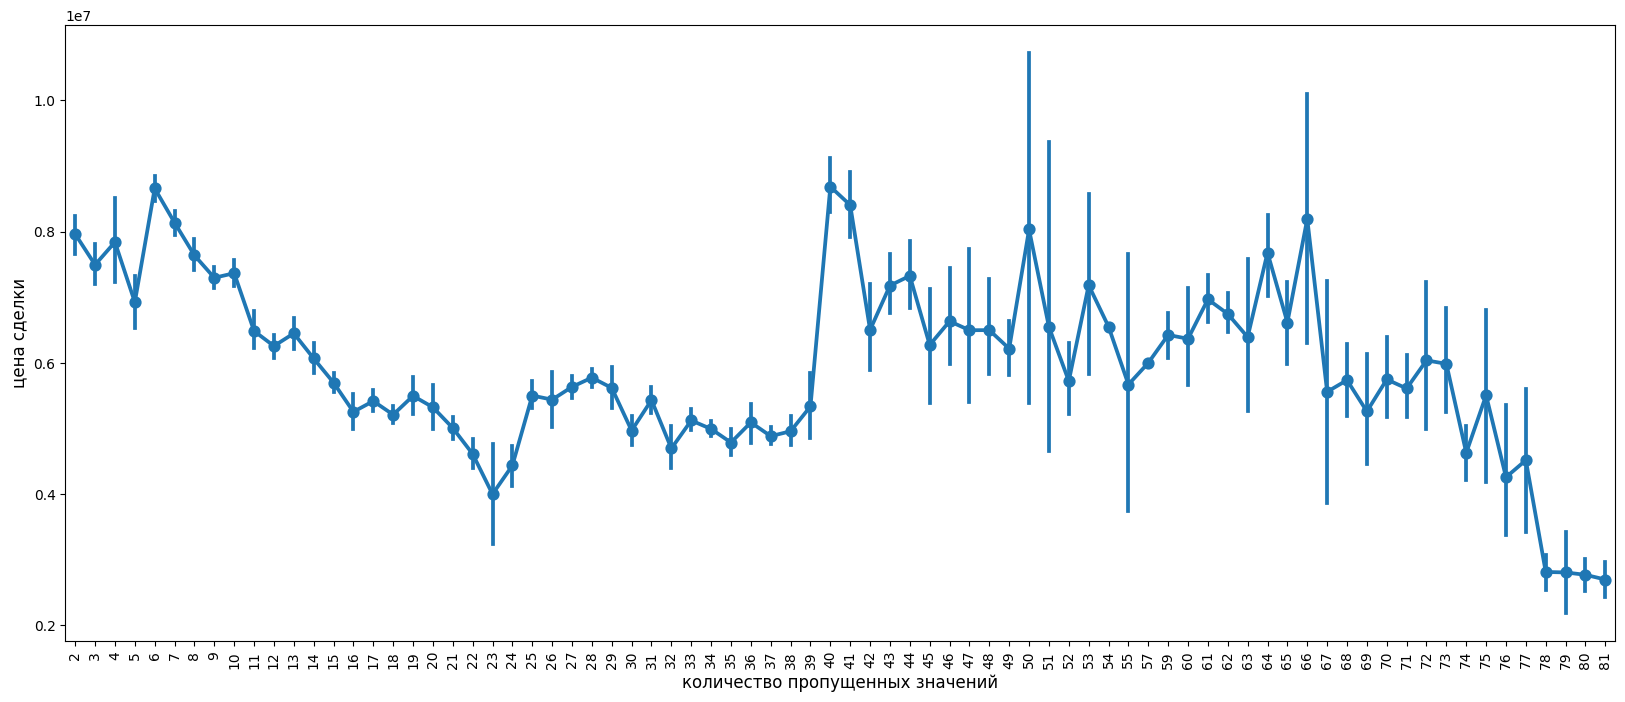

In [62]:
plt.figure(figsize=(20, 8))
sns.pointplot(x='null_count', y='price_doc', data=train_data)
plt.ylabel('цена сделки', fontsize=12)
plt.xlabel('количество пропущенных значений', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

На графике наблюдается **слабая отрицательная корреляция** – чем больше пропущенных значений, тем меньше цена квартиры.  
_Возможная причина_: дешевые квартиры хуже описаны в БД в отличие от дорогих.

Численно проверим наличие отрицательной корреляции через корреляцию Спирмена.

In [63]:
from scipy.stats import spearmanr

spearman_corr, spearman_p = spearmanr(train_data['null_count'], train_data['price_doc'])

print(f"Корреляция Спирмена: {spearman_corr:.3f} | p-value: {spearman_p:.10f}")
print(f"Интерпретация: {'Отрицательная' if spearman_corr < 0 else 'Положительная'} зависимость")

Корреляция Спирмена: -0.216 | p-value: 0.0000000000
Интерпретация: Отрицательная зависимость


Посмотрим на корреляцию top@20 фичей с целевым объектом

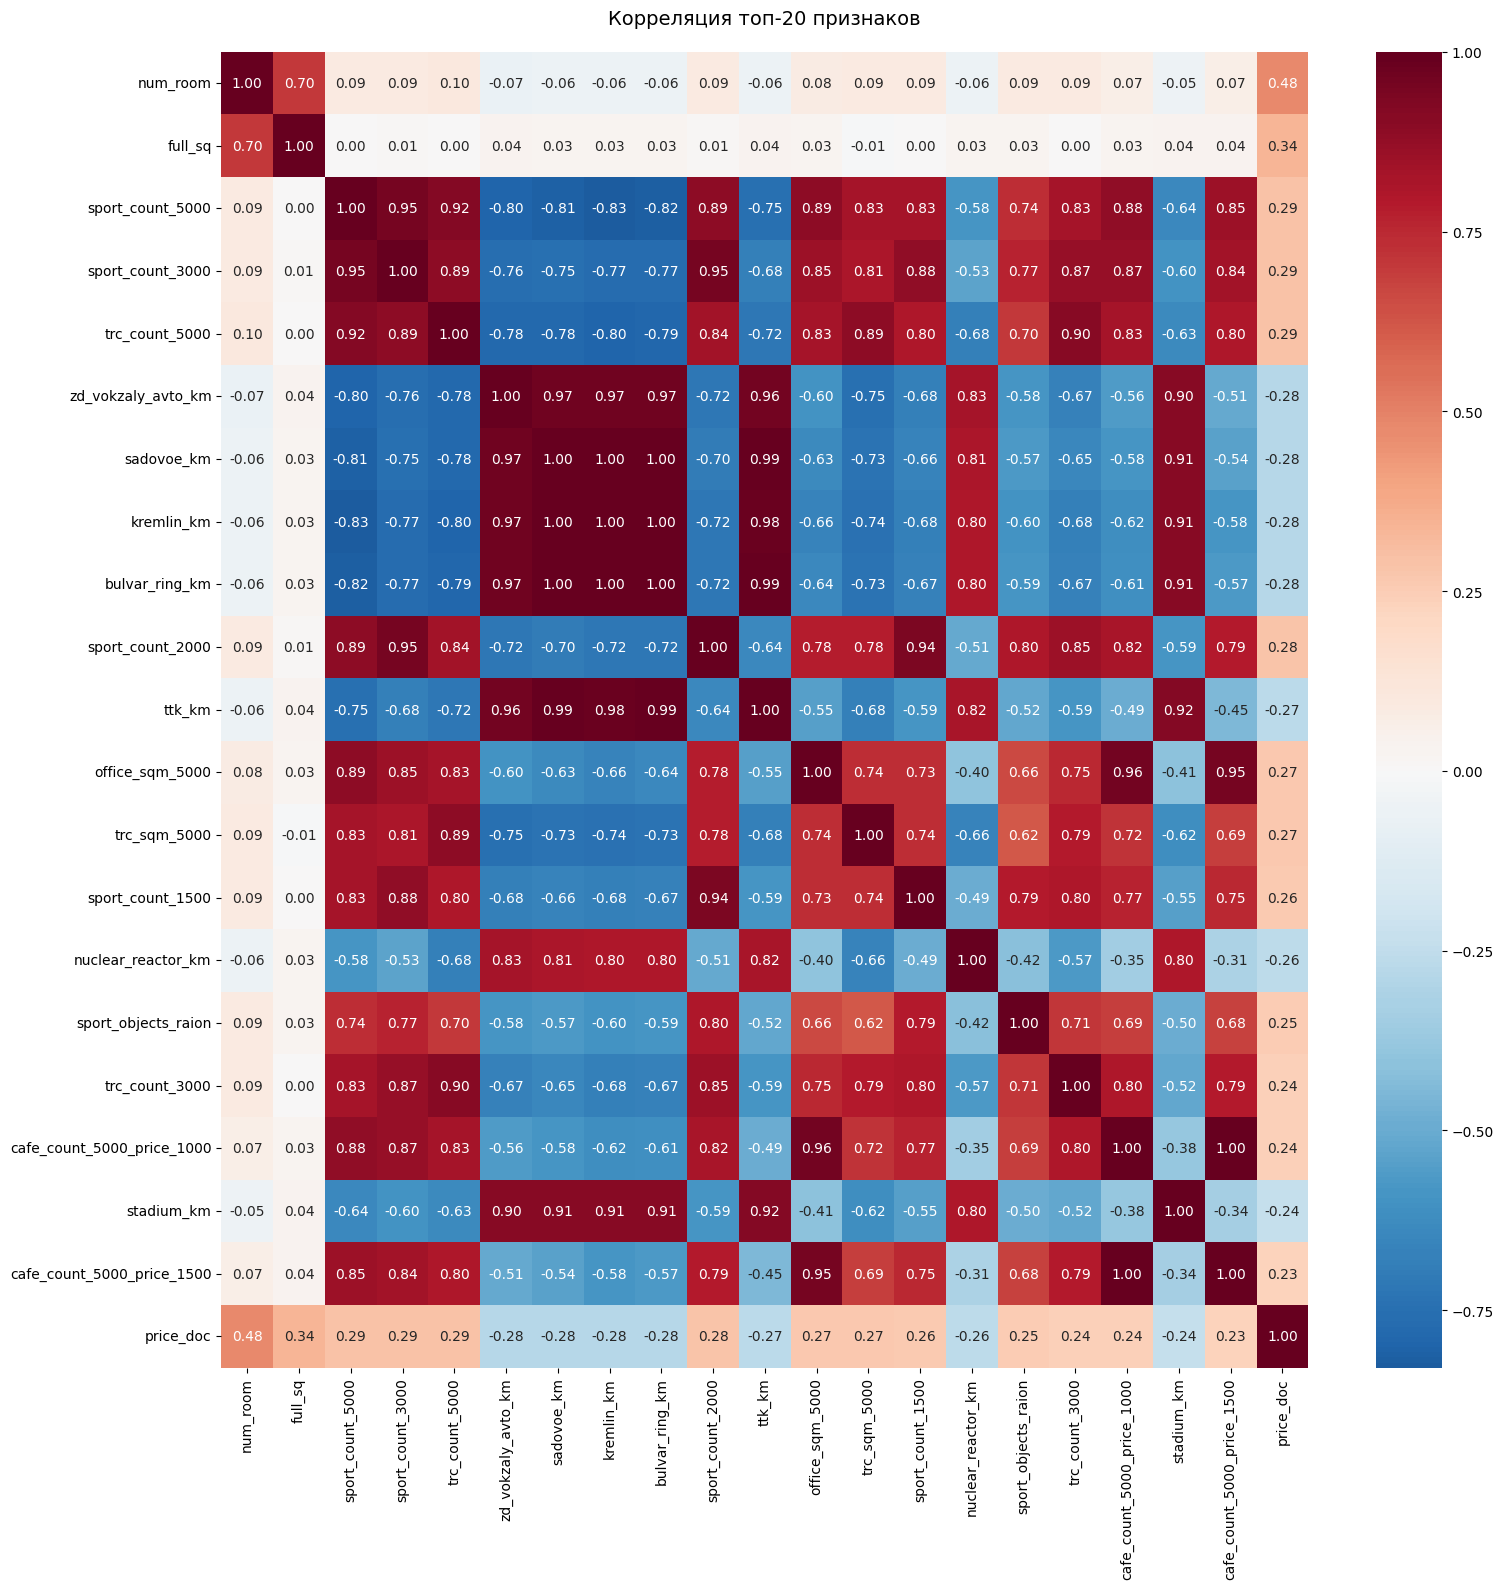

In [64]:
plt.figure(figsize=(16, 16))

top_n = 20
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
top_features = train_data[numeric_columns].corr()['price_doc'].abs().sort_values(ascending=False).index[1:top_n+1]
corr_matrix = train_data[top_features.tolist() + ['price_doc']].corr()

sns.heatmap(corr_matrix.round(2), annot=True, cmap='RdBu_r', center=0, 
            annot_kws={"size": 10}, fmt='.2f')
plt.title(f'Корреляция топ-{top_n} признаков', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [65]:
top_features

Index(['num_room', 'full_sq', 'sport_count_5000', 'sport_count_3000', 'trc_count_5000', 'zd_vokzaly_avto_km', 'sadovoe_km', 'kremlin_km', 'bulvar_ring_km', 'sport_count_2000', 'ttk_km', 'office_sqm_5000', 'trc_sqm_5000', 'sport_count_1500', 'nuclear_reactor_km', 'sport_objects_raion', 'trc_count_3000', 'cafe_count_5000_price_1000', 'stadium_km', 'cafe_count_5000_price_1500'], dtype='object')

#### price_doc
Рассмотрим как изменялись цены на недвижимость с течением времени.

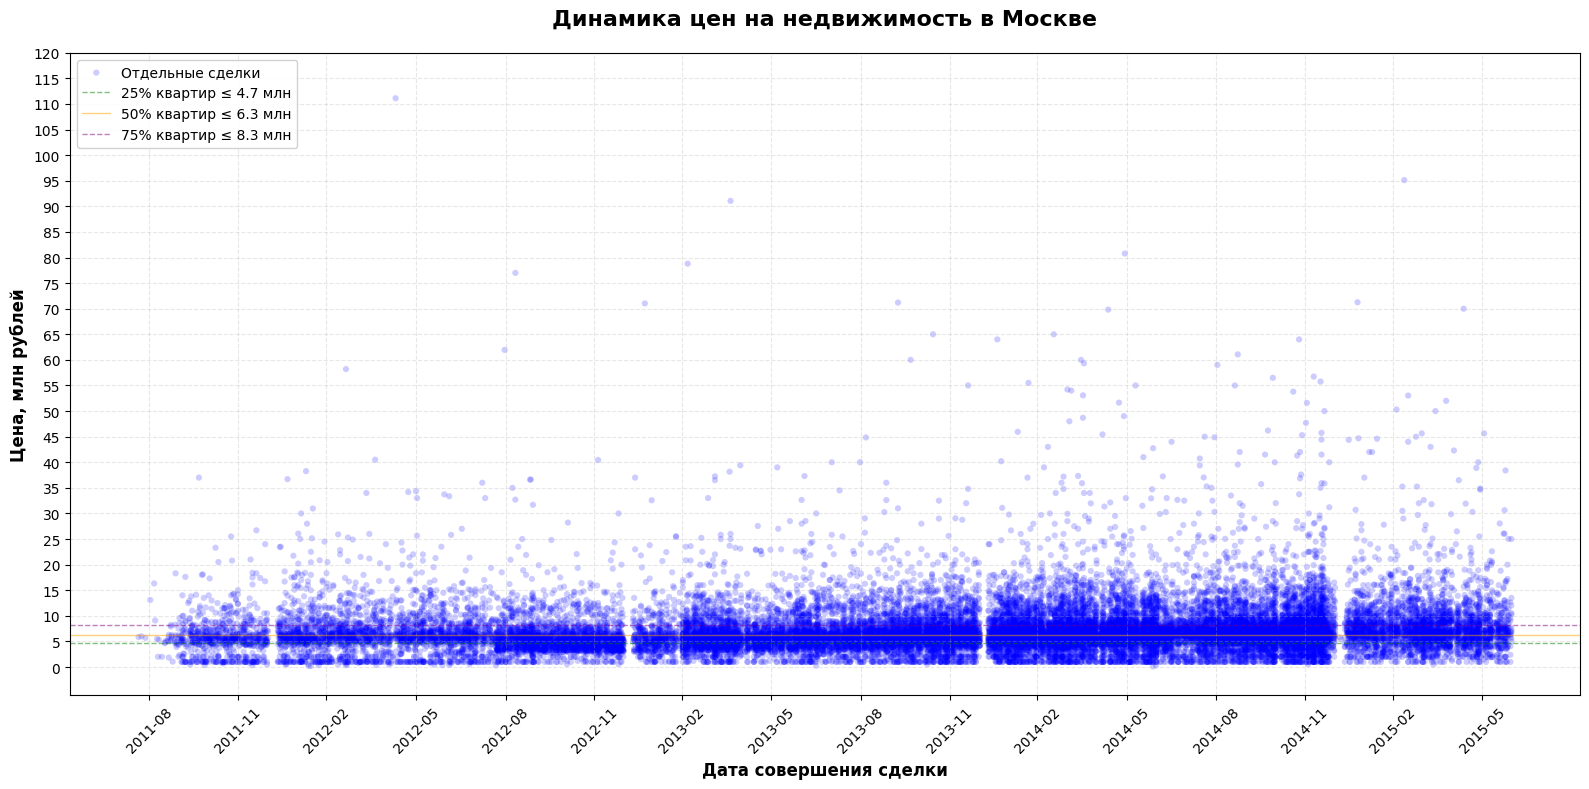

In [66]:
plt.figure(figsize=(16, 8))

dates_num = train_data['timestamp'].map(pd.Timestamp.toordinal)
prices = train_data['price_doc'] / 1000000

plt.scatter(dates_num, prices, alpha=0.2, s=20, color='blue', label='Отдельные сделки', edgecolors='none')

date_ticks = pd.date_range(train_data['timestamp'].min(), train_data['timestamp'].max(), freq='3M')
plt.xticks(
    [pd.Timestamp(d).toordinal() for d in date_ticks], 
    [d.strftime('%Y-%m') for d in date_ticks], 
    rotation=45, fontsize=10)


plt.ylabel('Цена, млн рублей', fontsize=12, fontweight='bold')
plt.xlabel('Дата совершения сделки', fontsize=12, fontweight='bold')

y_ticks = np.arange(0, prices.max() + 10, 5)
plt.yticks(y_ticks, [f'{int(y)}' for y in y_ticks], fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')

for q, color, style in [(0.25, 'green', '--'), (0.5, 'orange', '-'), (0.75, 'purple', '--')]:
    q_value = prices.quantile(q)
    plt.axhline(y=q_value, 
                color=color, 
                linestyle=style, 
                alpha=0.5, 
                linewidth=1, 
                label=f'{int(q*100)}% квартир ≤ {q_value:.1f} млн')


plt.title('Динамика цен на недвижимость в Москве', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
plt.tight_layout()
plt.show()

Видно сделки, значительно превышающие общий уровень цен.  
Теперь построим распределение цен на недвижимость и попробуем избавиться от выбросов.

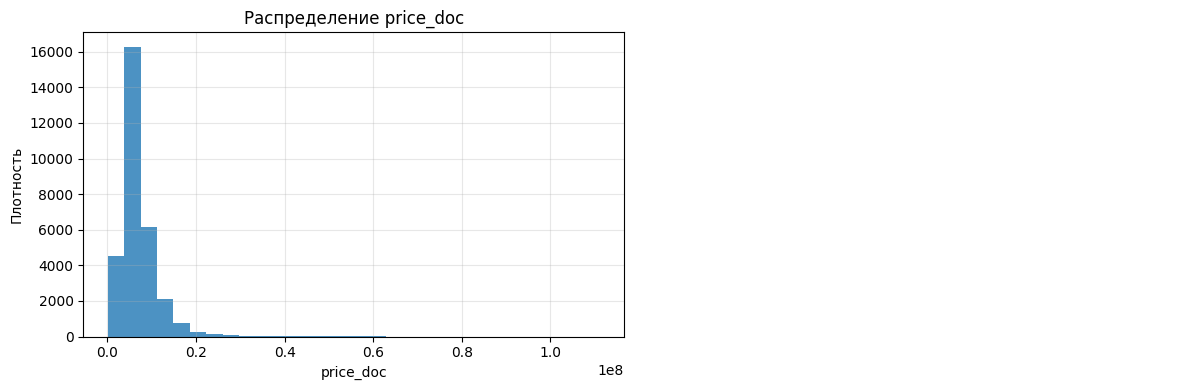

In [67]:
visualize_distributions(train_data, ['price_doc'])

Преобразуем экспоненциальное распределение в близкое к нормальному.

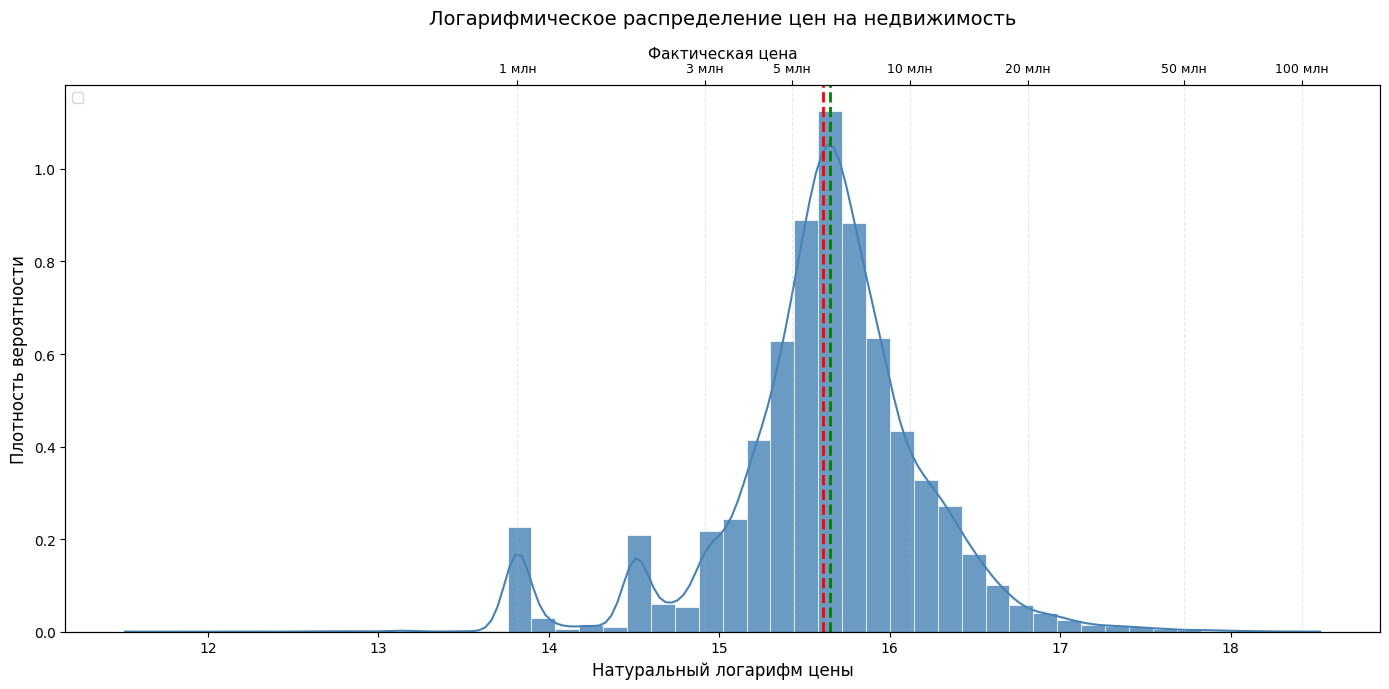

In [68]:
plt.figure(figsize=(14, 7))

log_prices = np.log(train_data['price_doc'])
mean_log = log_prices.mean()
median_log = log_prices.median()

sns.histplot(log_prices, 
             bins=50, kde=True, 
             color='steelblue', edgecolor='white', 
             linewidth=0.5, alpha=0.8, stat='density')

plt.xlabel('Натуральный логарифм цены', fontsize=12, fontweight='medium')
plt.ylabel('Плотность вероятности', fontsize=12, fontweight='medium')
plt.title('Логарифмическое распределение цен на недвижимость', 
          fontsize=14, pad=15)

plt.axvline(mean_log, color='red', linestyle='--', linewidth=2, 
            label=f'Среднее: e^{mean_log:.1f} = {np.exp(mean_log)/1e6:.1f} млн руб')
plt.axvline(median_log, color='green', linestyle='--', linewidth=2, 
            label=f'Медиана: e^{median_log:.1f} =  {np.exp(median_log)/1e6:.1f} млн руб')

ax = plt.gca()
ax2 = ax.twiny()

key_prices_millions = [1, 3, 5, 10, 20, 50, 100]
key_log_values = [np.log(p * 1_000_000) for p in key_prices_millions]

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(key_log_values)
ax2.set_xticklabels([f'{p} млн' for p in key_prices_millions], fontsize=9)
ax2.set_xlabel('Фактическая цена', fontsize=11, fontweight='medium')

plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

Избавляемся от выбросов

In [69]:
upper_limit = np.percentile(train_data['price_doc'], 99)
lower_limit = np.percentile(train_data['price_doc'], 1)

train_data.loc[(train_data['price_doc'] > upper_limit), 'price_doc'] = upper_limit
train_data.loc[(train_data['price_doc'] < lower_limit), 'price_doc'] = lower_limit

#### num_room
Избавим num_room от выбросов по след. правилу: Если (num_room == 0) => выброс.

В 2016 году была зафиксирована самая большая квартира с 20 комнатами в Москве ([источник](https://www.mirkvartir.ru/journal/analytics/2016/08/22/samaa-mnogokomnatnaa-kvartira-v-rossii-sostoit-iz-20-pomesenii/?utm_source=chatgpt.com&utm_referrer=https%3A%2F%2Fchatgpt.com%2F))

In [ ]:
train_data = train_data[(train_data['num_room'] != 0) & (train_data['num_room'] =< 20)]
test_data = test_data[(test_data['num_room'] != 0) & (test_data['num_room'] =< 20)]

Заполняем пропущенные значения num_room ориентируясь по timestamp, sub_area и full_sq.

In [71]:
def predict_rooms(
    row: pd.Series,
    median_by_area_year: dict,
) -> float:
    """
    Предсказывает количество комнат на основе площади, района и года сделки.
    
    Args:
        row: Строка DataFrame с признаками sub_area, year, full_sq, num_room
        median_by_area_year: Словарь с медианой кв.м на комнату по району и году
    
    Returns:
        Предсказанное количество комнат
    """
    if not pd.isna(row['num_room']):
        return row['num_room']
    
    sq_per_room = None
    key = (row['sub_area'], row['year'])
    if key in median_by_area_year:
        sq_per_room = median_by_area_year[key]
    else:    
        key = (row['sub_area'], row['year'] + 2)
        sq_per_room = median_by_area_year[key]

    predicted = max(1, round(row['full_sq'] / sq_per_room))
    return predicted


def fill_num_room(df: pd.DataFrame, reference_df: pd.DataFrame=None):
    """
    Заполняет пропущенные значения в столбце num_room.
    
    Args:
        df: DataFrame для заполнения пропусков
        reference_df: DataFrame для расчета статистик (по умолчанию используется df)
    
    Returns:
        DataFrame с заполненными пропусками в num_room
    """
    df = df.copy()
    
    if reference_df is None:
        reference_df = df.copy()

    df['year'] = pd.to_datetime(df['timestamp']).dt.year
    reference_df['year'] = pd.to_datetime(reference_df['timestamp']).dt.year
    
    valid_ref = reference_df.dropna(subset=['num_room']).copy()    
    valid_ref['sq_per_room'] = valid_ref['full_sq'] / valid_ref['num_room']
    
    median_by_area_year = valid_ref.groupby(['sub_area', 'year'])['sq_per_room'].median().to_dict()
    
    mask = df['num_room'].isna()
    df.loc[mask, 'num_room'] = df[mask].apply(
            lambda row: predict_rooms(row, median_by_area_year), 
            axis=1
    )

    df = df.drop('year', axis=1)

    return df


train_data = fill_num_room(train_data)
test_data = fill_num_room(test_data, reference_df=train_data)

Визуализирует распределение количества комнат и их зависимость от площади.

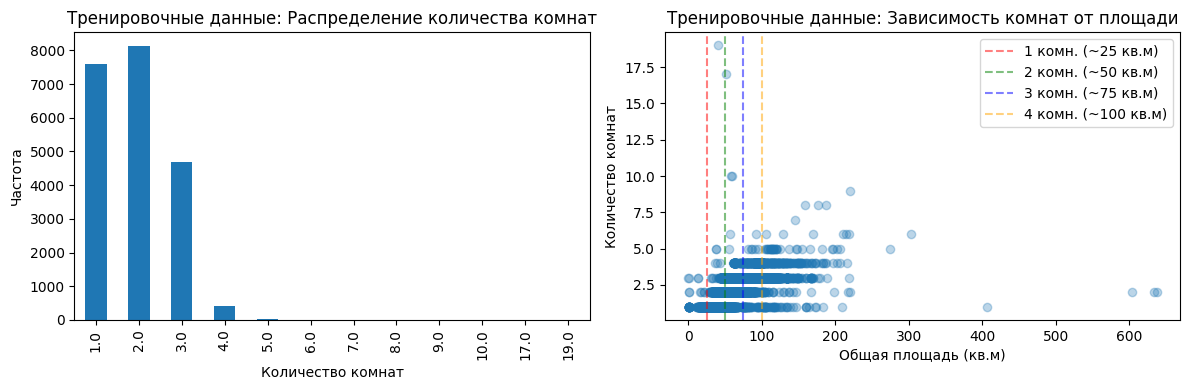

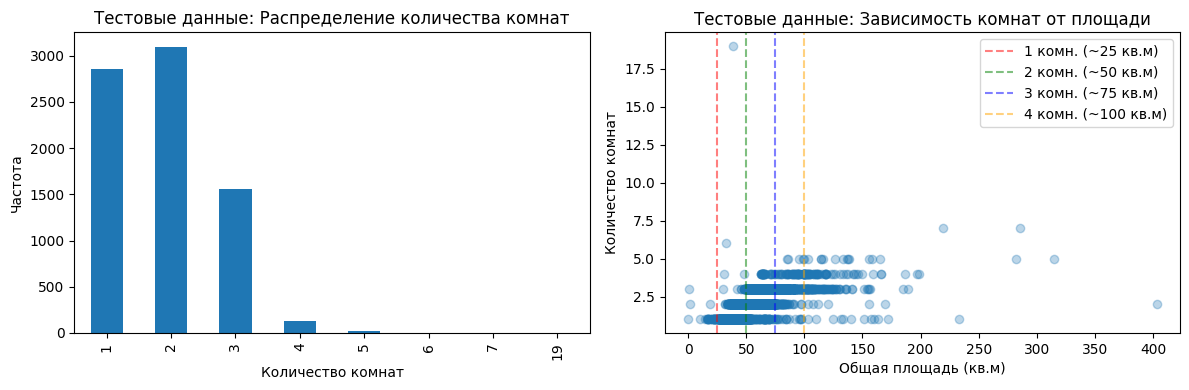

In [72]:

def plot_num_room_distribution(df: pd.DataFrame, title: str) -> None:
    """
    Визуализирует распределение количества комнат и их зависимость от площади.
    
    Функция создает два графика для анализа признака num_room:
    1. Гистограмму распределения количества комнат
    2. Диаграмму рассеяния зависимости количества комнат от общей площади
    
    Args:
        df (pd.DataFrame): DataFrame с данными, содержащий колонки 'num_room' и 'full_sq'
        title (str): Заголовок для графиков, обычно указывающий тип данных 
                     (например, 'Тренировочные данные' или 'Тестовые данные')
                     
    Returns:
        None: Функция отображает графики, но не возвращает значений
    
    Notes:
        - На диаграмме рассеяния добавляются вертикальные линии, показывающие типичную площадь
          для разного количества комнат (из расчета ~25 кв.м на комнату)
        - Графики помогают выявить аномалии и понять распределение данных
    """

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    df['num_room'].value_counts().sort_index().plot(kind='bar', ax=axes[0])

    axes[0].set_title(f'{title}: Распределение количества комнат')
    axes[0].set_xlabel('Количество комнат')
    axes[0].set_ylabel('Частота')
    
    axes[1].scatter(df['full_sq'], df['num_room'], alpha=0.3)
    axes[1].set_title(f'{title}: Зависимость комнат от площади')
    axes[1].set_xlabel('Общая площадь (кв.м)')
    axes[1].set_ylabel('Количество комнат')
    
    for rooms, color in zip([1, 2, 3, 4], ['red', 'green', 'blue', 'orange']):
        typical_sq = rooms * 25 
        axes[1].axvline(x=typical_sq, color=color, linestyle='--', alpha=0.5, 
                       label=f'{rooms} комн. (~{typical_sq} кв.м)')
    
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_num_room_distribution(train_data, 'Тренировочные данные')
plot_num_room_distribution(test_data, 'Тестовые данные')

#### Фичи измеряющиеся количество объектов находящийся в радиусе N метров:

- sport_count_5000, sport_count_3000, sport_count_2000, sport_count_1500 : Количество спортивных объектов в радиусе (1500,3000,5000) метров
- trc_count_5000, trc_count_3000 : Количество торговых центров в радиусе (3000,5000) метров
- office_sqm_5000, trc_sqm_5000 : Площадь офисов/ТРЦ в радиусе 5000 м
- cafe_count_5000_price_1000, cafe_count_5000_price_1500 : Количество кафе с определенным ценовым диапазоном в радиусе 5000 м

- sport_objects_raion : Количество спортивных объектов в районе

В целом, логично, что чем больше объектов поблизости — тем больше будет цена на квартиры.   
Важно понимать, что если объектов в радиусе 1500 метров составляет 10, то в радиусе 3000 не может быть меньше 10.

Ориентируясь по радиусам избавимся от аномалий

In [73]:
radius_cols = ['sport_count_1500','sport_count_2000','sport_count_3000','sport_count_5000']
trc_cols = ['trc_count_3000','trc_count_5000']
cafe_count_cols = ['cafe_count_5000_price_1000','cafe_count_5000_price_1500']
raion_col = 'sport_objects_raion'



def clean_radius_timeaware(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    Исправляет (non-decreasing) счётчики по радиусам, но применяет коррекцию внутри временных групп.
    По умолчанию группирует по годам, извлекая год из time_col.
    - cols: список колонок с радиусными счётчиками (например: ['sport_count_1500', ...])
    - time_col: колонка с временной меткой
    Возвращает копию df с исправленными колонками cols (NaN будут заполнены корректными накопленными значениями).
    """
    df = df.copy()

    time_col = 'timestamp'

    cols_sorted = sorted(cols, key=lambda x: int(x.split('_')[-1]))

    years = pd.to_datetime(df[time_col], errors='coerce').dt.year
    years = years.fillna(-1).astype(int)
    df['_time_group'] = years

    for tg, idx in df.groupby('_time_group').groups.items():
        sub_idx = idx  # индексы строк в этой группе
        sub = df.loc[sub_idx, cols_sorted]

        sub_num = sub.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan)

        arr = np.nan_to_num(sub_num.values, nan=0.0)
        corrected = np.maximum.accumulate(arr, axis=1)
        df.loc[sub_idx, cols_sorted] = corrected

    df.drop(columns=['_time_group'], inplace=True)
    return df



train_data = clean_radius_timeaware(train_data, radius_cols)
train_data = clean_radius_timeaware(train_data, trc_cols)
train_data = clean_radius_timeaware(train_data, cafe_count_cols)

Теперь оценим и избавимся от аномалий для фичи sport_objects_raion

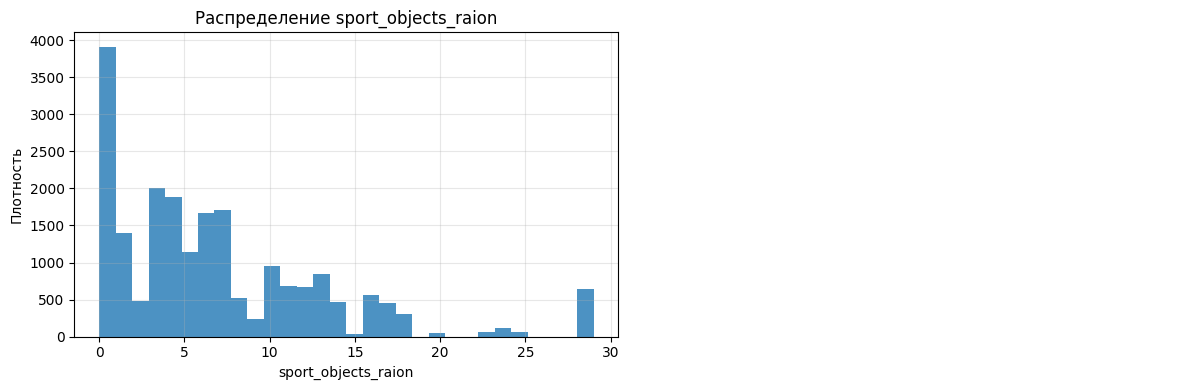

np.int64(3912)

In [74]:
visualize_distributions(train_data, ['sport_objects_raion'])

# TODO: стоит ли нам избавиться от 0
(train_data['sport_objects_raion'] == 0).sum()

In [75]:
train_data[['sport_objects_raion']] = train_data[['sport_objects_raion']].apply(lambda x: np.log1p(x))

upper = train_data['sport_objects_raion'].quantile(0.95)
train_data['sport_objects_raion'] = np.minimum(train_data['sport_objects_raion'], upper)

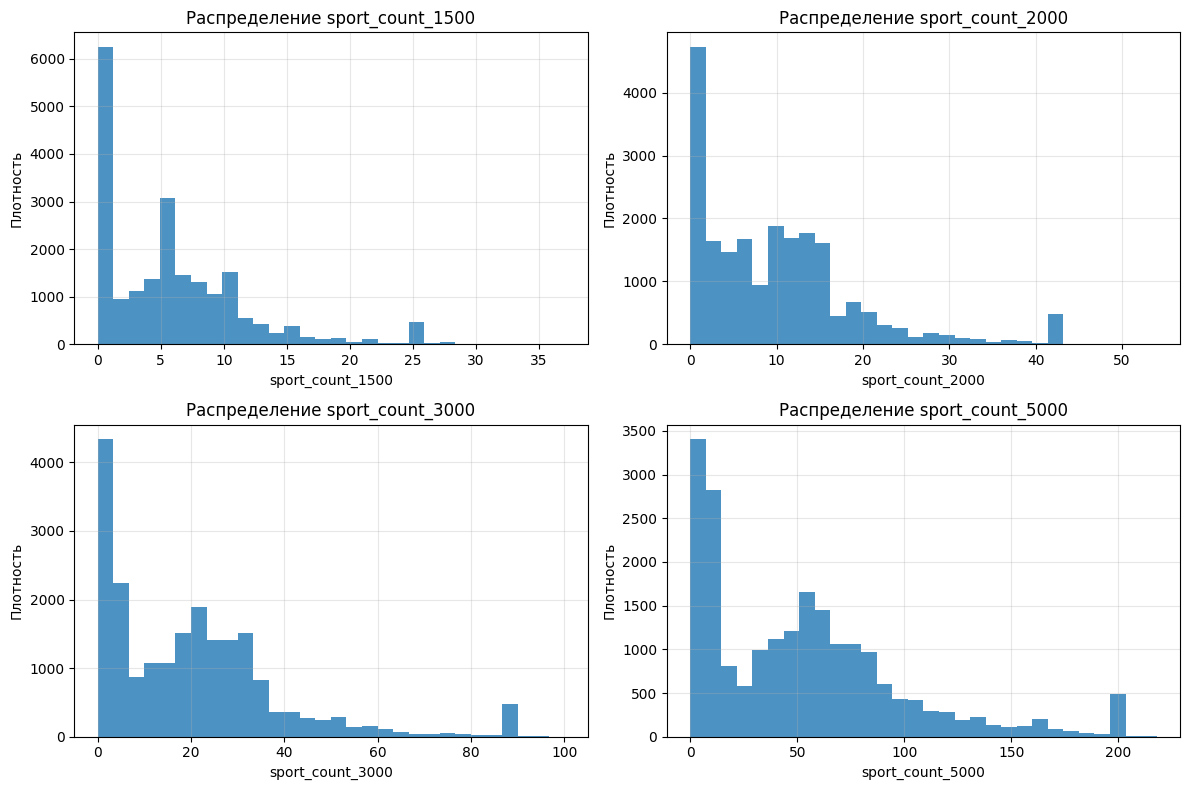

In [76]:
visualize_distributions(train_data, radius_cols)

In [77]:
train_data[radius_cols] = train_data[radius_cols].apply(lambda x: np.log1p(x))

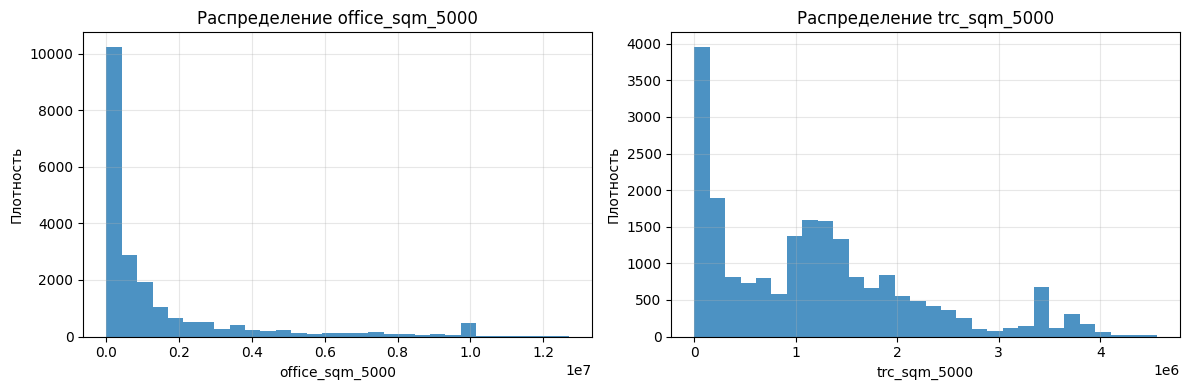

In [78]:
sqms_cols = ['office_sqm_5000', 'trc_sqm_5000']
visualize_distributions(train_data, sqms_cols)

In [79]:
train_data[sqms_cols] = train_data[sqms_cols].apply(lambda x: np.log1p(x))
# train_data = remove_outline(df=train_data, cols=sqms_cols)

#### .

#### Фичи показывающиеся расстояние до опред. объекта
Расстояние до:
- zd_vokzaly_avto_km : Железнодорожных вокзалов (на автомобиле)
- sadovoe_km : Садового кольца
- kremlin_km : Кремля (центра Москвы)
- bulvar_ring_km : Бульварного кольца
- ttk_km : Третьего транспортного кольца (ТТК)
- nuclear_reactor_km : Ядерного реактора
- stadium_km : Стадиона

Фичи подобного характера показывают расстояние до опред. объекта, то есть расстояния могут быть как малыми так и большими (в рамках разумного).   
Предварительно расмотрим плотность распределения каждой фичи и избавимся от тех, которые будут отрицательными или аномально большими.

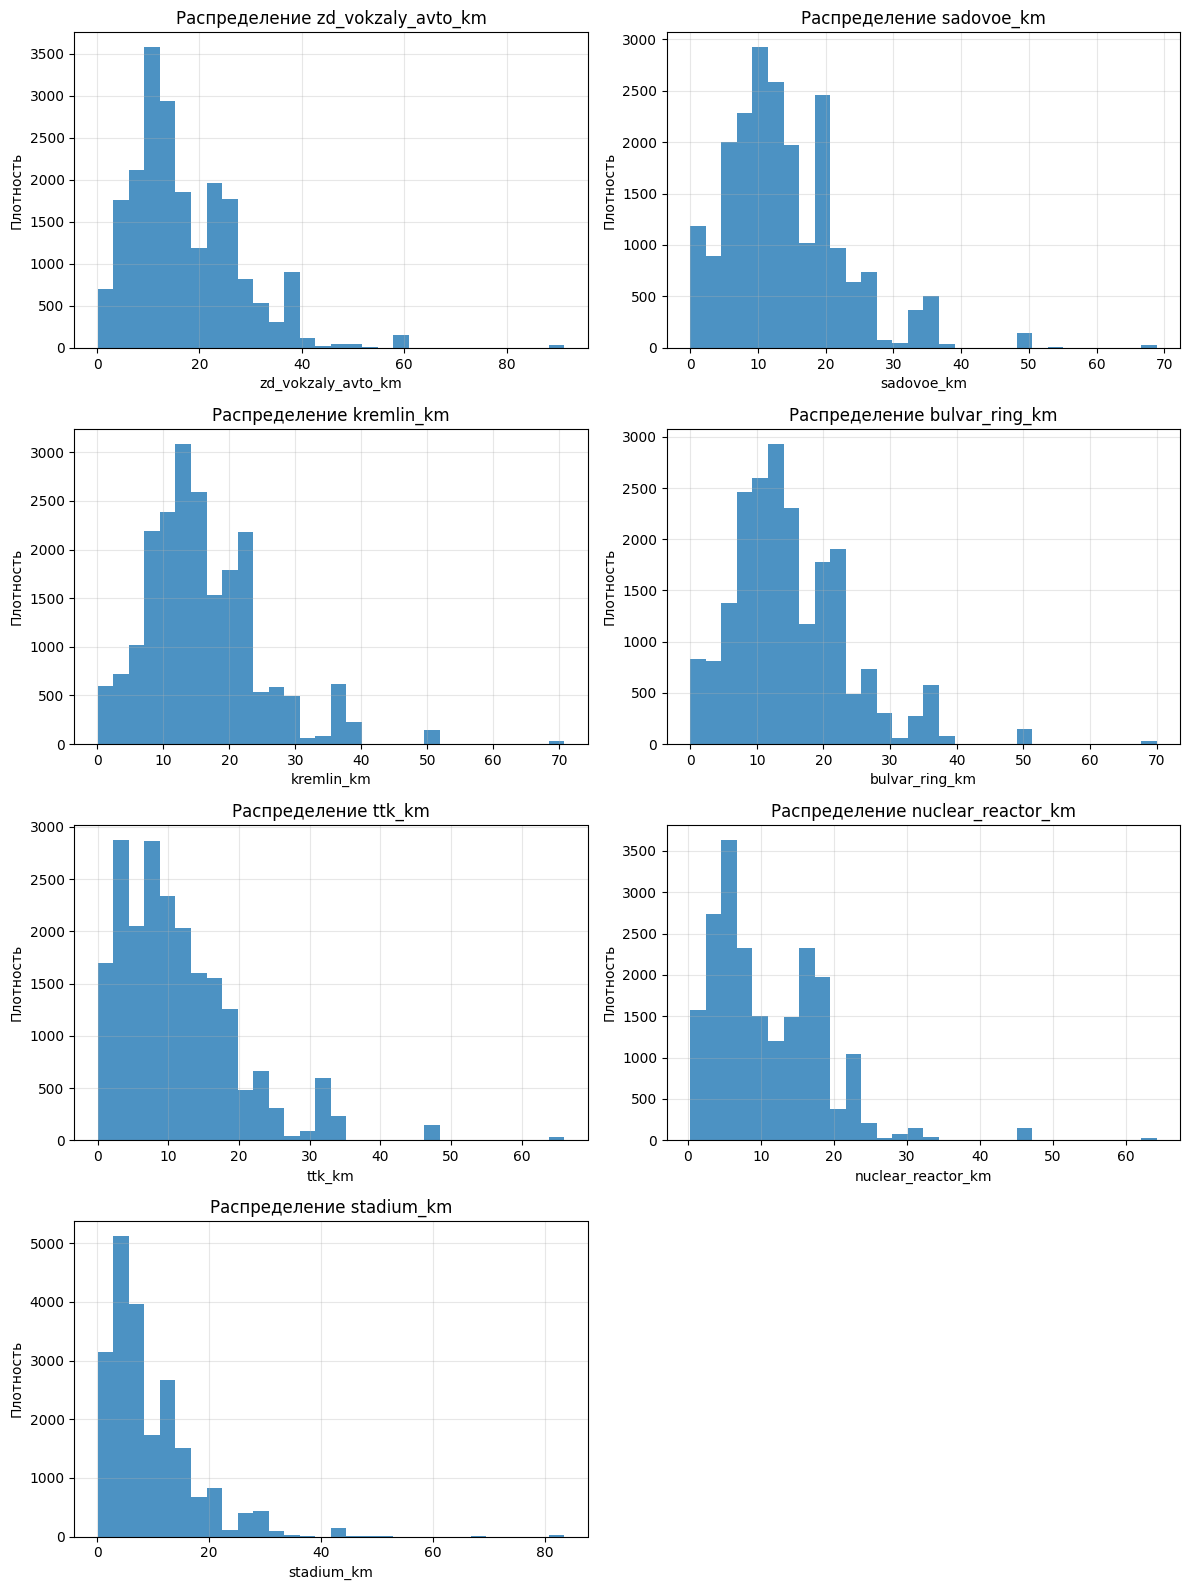

In [80]:
dist_features = ["zd_vokzaly_avto_km", "sadovoe_km", "kremlin_km", "bulvar_ring_km", "ttk_km", "nuclear_reactor_km", "stadium_km"]

visualize_distributions(train_data, dist_features)

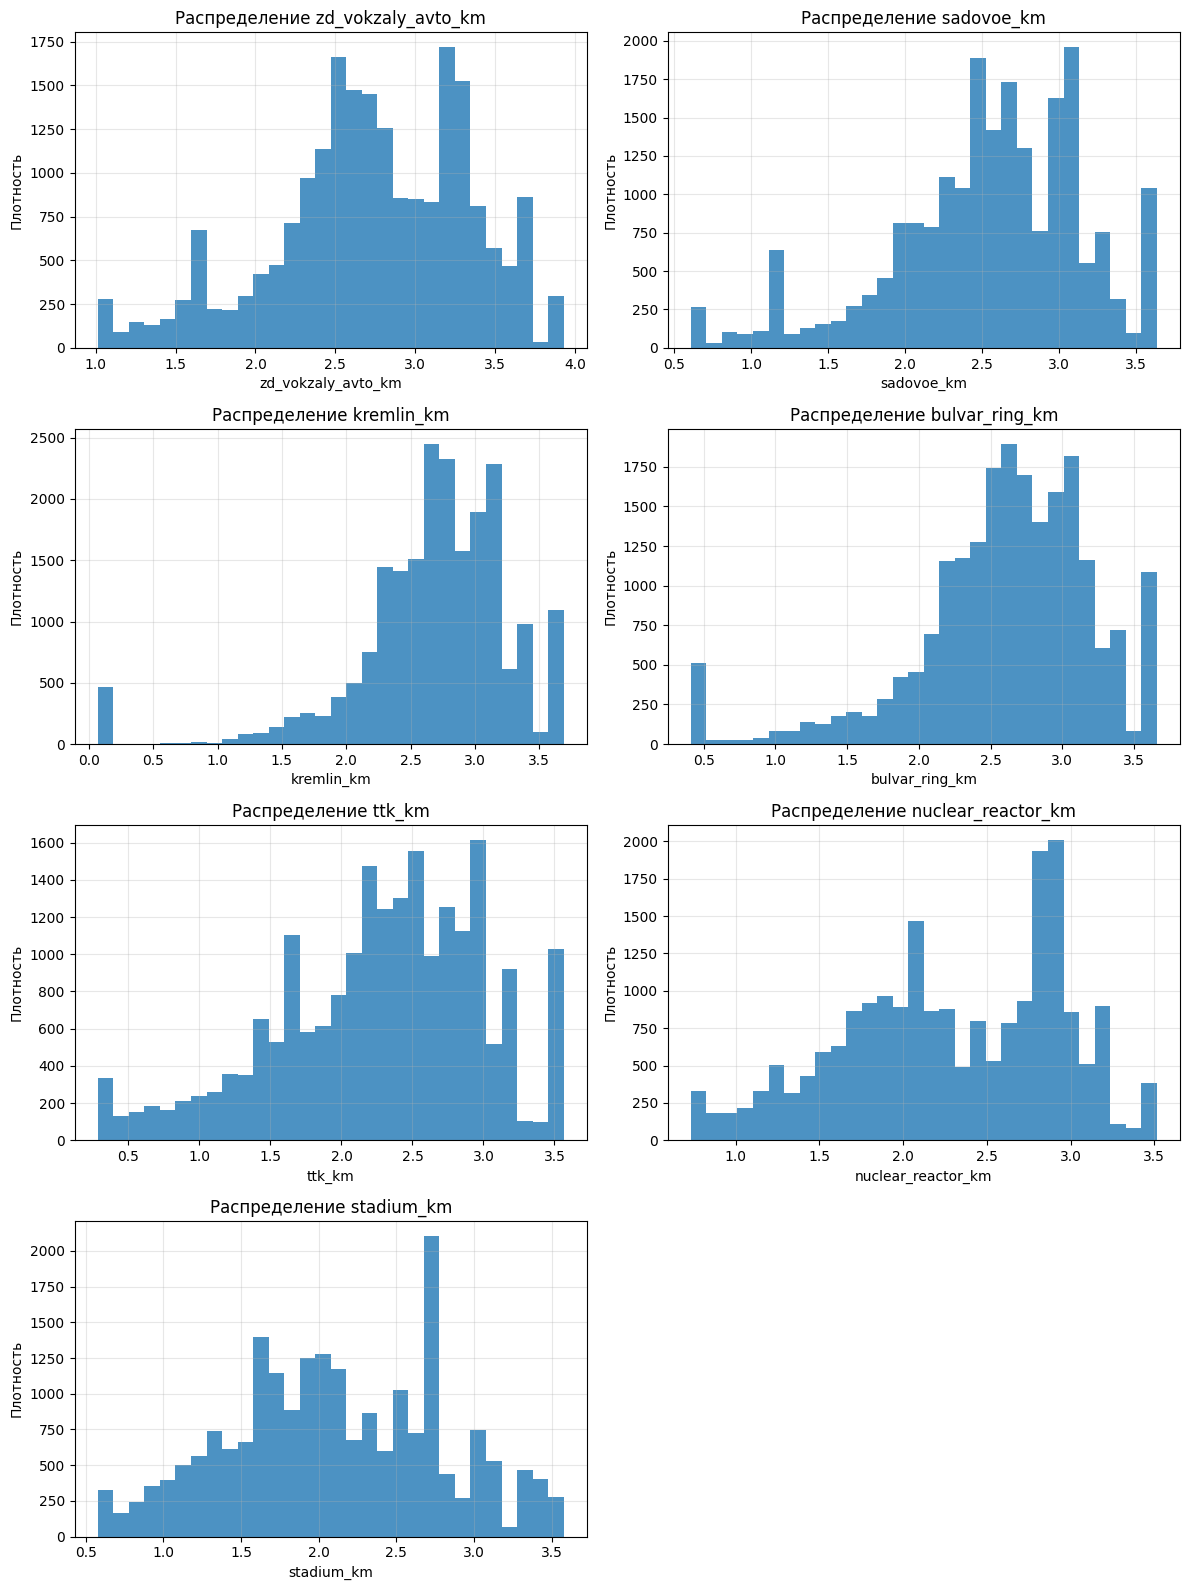

In [81]:
train_data[dist_features] = train_data[dist_features].apply(lambda x: np.log1p(x))
train_data = remove_outline(df=train_data, cols=dist_features)

visualize_distributions(train_data, dist_features)

#### Фичи показывающие транспортную доступность
Удалим от пропущенных значений, поскольку их не так уж много.

In [82]:
transport_cols = ['metro_km_walk','ID_railroad_station_walk','railroad_station_walk_min','railroad_station_walk_km','metro_min_walk']

train_data[transport_cols].isna().sum()

metro_km_walk                25
ID_railroad_station_walk     25
railroad_station_walk_min    25
railroad_station_walk_km     25
metro_min_walk               25
dtype: int64

In [83]:
train_data.dropna(subset=transport_cols, inplace=True)

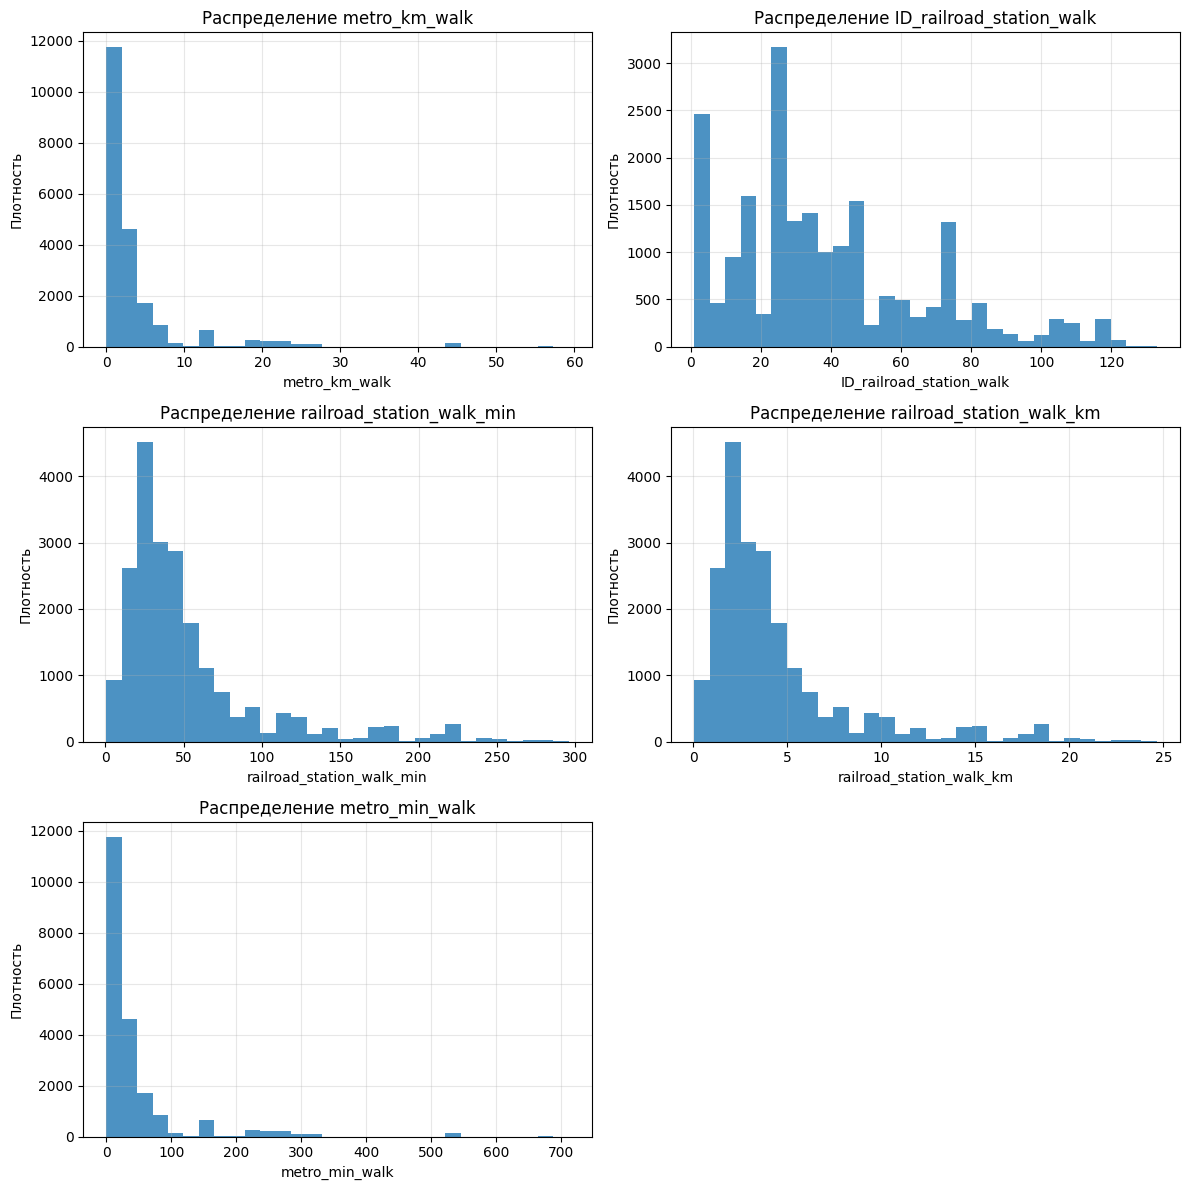

In [84]:
visualize_distributions(train_data, transport_cols)

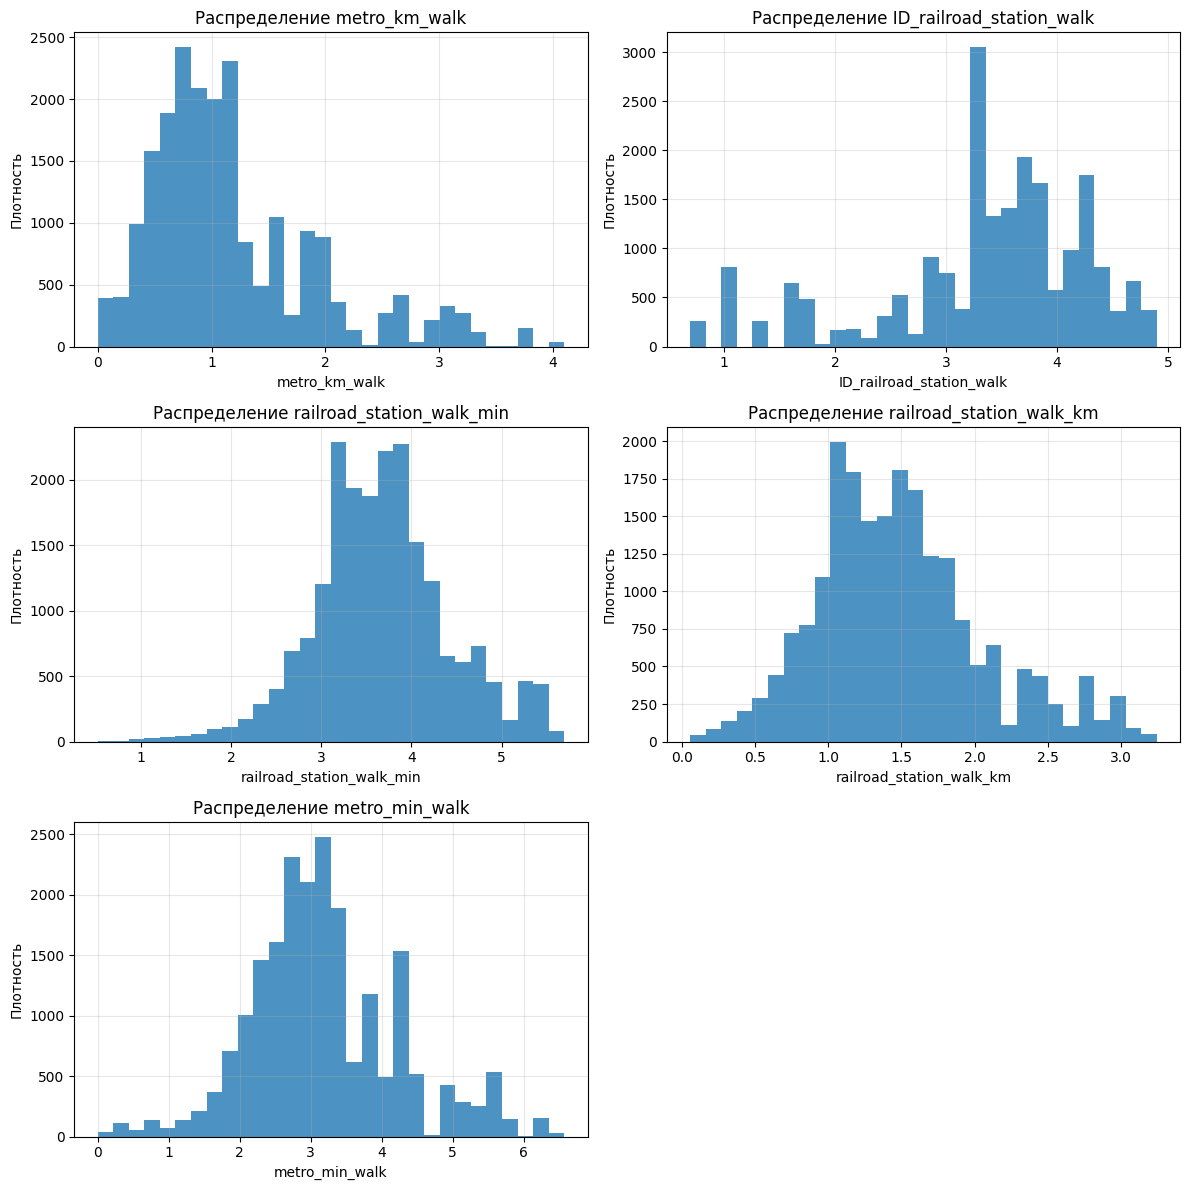

In [85]:
train_data[transport_cols] = train_data[transport_cols].apply(lambda x: np.log1p(x))

visualize_distributions(train_data, transport_cols)

#### Фичи показывающие среднюю/максимально среднюю цену в кафе в радиусе N метров

Будем заполнять пропущенные значения в признаках кафе (цены и суммы по разным радиусам):
1. Для объектов, где рядом нет кафе, заполняем суммы и средние цены нулями.
2. Для остальных заполняем пропуски медианой:
    - сначала внутри группы района (sub_area) и месяца (year_month),
    - затем по району,
    - затем по месяцу.
 3. Для сумм по 5000 м делается приближённая реконструкция через avg_price * количество кафе.

In [86]:
cafe_price_cols = [
        'cafe_avg_price_5000','cafe_sum_5000_max_price_avg','cafe_sum_5000_min_price_avg',
        'cafe_avg_price_3000','cafe_sum_3000_max_price_avg','cafe_sum_3000_min_price_avg',
        'cafe_sum_2000_max_price_avg','cafe_avg_price_2000','cafe_sum_2000_min_price_avg',
        'cafe_avg_price_1500','cafe_sum_1500_max_price_avg','cafe_sum_1500_min_price_avg',
        'cafe_sum_1000_min_price_avg','cafe_sum_1000_max_price_avg','cafe_avg_price_1000',
        'cafe_avg_price_500','cafe_sum_500_max_price_avg','cafe_sum_500_min_price_avg'
    ]


def fill_cafe_prices(df: pd.DataFrame):

    df = df.copy()
    df['year_month'] = pd.to_datetime(df['timestamp']).dt.to_period('M')
    
    mask_no_cafes = (df[cafe_count_cols].sum(axis=1) > 0).astype(int) == 0
    sum_cols = [c for c in cafe_price_cols if c.startswith('cafe_sum')]
    avg_cols = [c for c in cafe_price_cols if c.startswith('cafe_avg')]
    

    df.loc[mask_no_cafes, sum_cols] = df.loc[mask_no_cafes, sum_cols].fillna(0)
    df.loc[mask_no_cafes, avg_cols] = df.loc[mask_no_cafes, avg_cols].fillna(0)


    for col in cafe_price_cols:
        df[col] = df.groupby(['sub_area', 'year_month'])[col].transform(
            lambda x: x.fillna(x.median())
        )
        df[col] = df[col].fillna(
            df.groupby('sub_area')[col].transform('median')
        )
        df[col] = df[col].fillna(
            df.groupby('year_month')[col].transform('median')
        )
        
        if col.startswith('cafe_sum') and '5000' in col:

            counts_sum = df[cafe_count_cols].sum(axis=1)
            approx_avg_col = col.replace('sum', 'avg')
            
            if approx_avg_col in df.columns:
                mask_reconstruct = df[col].isna() & (counts_sum > 0) & (df[approx_avg_col].notna())
                df.loc[mask_reconstruct, col] = df.loc[mask_reconstruct, approx_avg_col] * counts_sum[mask_reconstruct]


    df.drop(columns=['year_month'], inplace=True)
    return df


train_data = fill_cafe_prices(df=train_data)
test_data = fill_cafe_prices(df=test_data)

Посмотрим на полученное плотность распределение фич

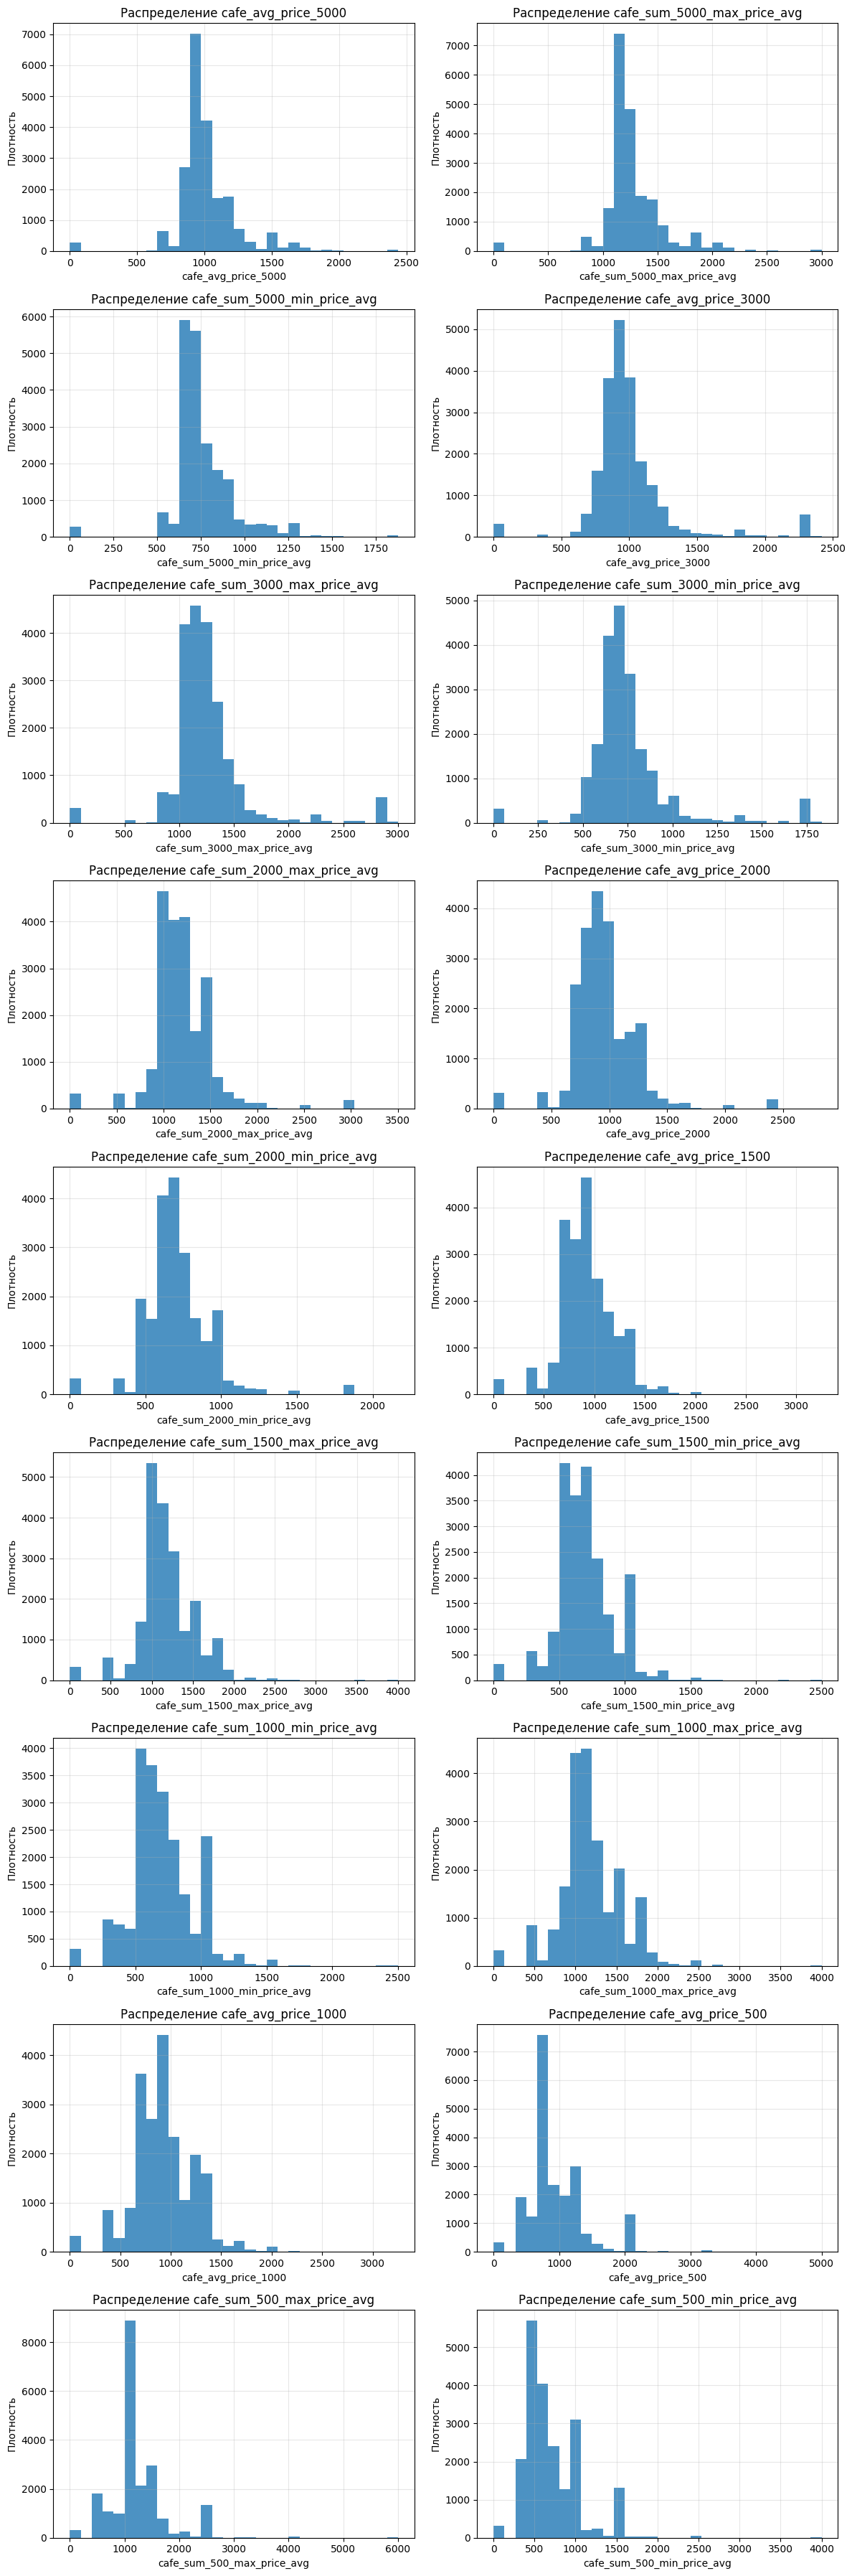

In [87]:
visualize_distributions(train_data, cafe_price_cols)

Избавимся от выбросов

In [88]:
train_data = remove_outline(train_data, cafe_count_cols)
test_data = remove_outline(df=test_data, cols=cafe_count_cols)

train_data[cafe_count_cols] = train_data[cafe_count_cols].apply(lambda x: np.log1p(x))
test_data[cafe_count_cols] = test_data[cafe_count_cols].apply(lambda x: np.log1p(x))

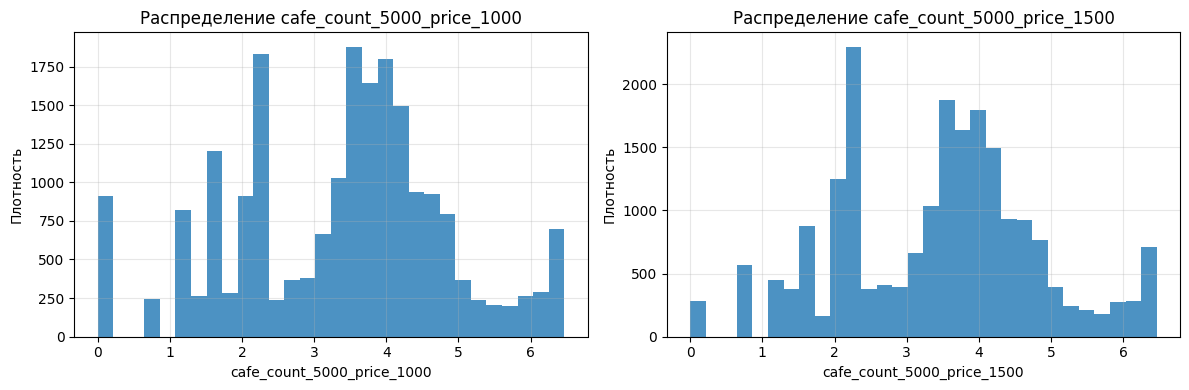

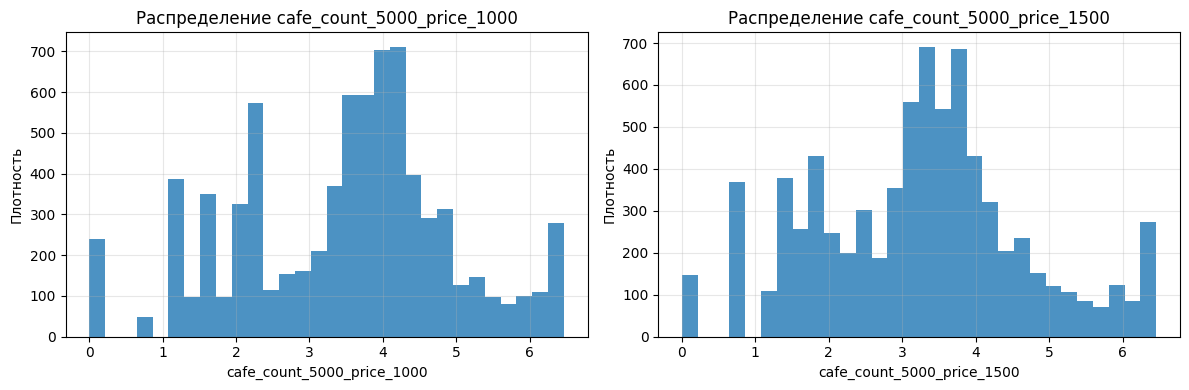

In [89]:
visualize_distributions(train_data, cafe_count_cols)
visualize_distributions(test_data, cafe_count_cols)

In [90]:
train_data[missing_data['column_name'].unique()].isna().mean()

ID_railroad_station_walk                  0.000
railroad_station_walk_min                 0.000
railroad_station_walk_km                  0.000
metro_km_walk                             0.000
metro_min_walk                            0.000
                                          ...  
theaters_viewers_per_1000_cap             0.809
museum_visitis_per_100_cap                0.809
load_of_teachers_preschool_per_teacher    0.809
provision_retail_space_sqm                1.000
provision_retail_space_modern_sqm         1.000
Length: 93, dtype: float64

In [91]:
missing_data = train_data.isnull().sum(axis=0).reset_index()
missing_data.columns = ['column_name', 'missing_count']
missing_data = missing_data.loc[(missing_data['missing_count'] > 0), :]
missing_data = missing_data.sort_values(by='missing_count')
ind = range(missing_data.shape[0])
len(missing_data['column_name'].unique())

63

#### child_on_acc_pre_school
Чем больше детей на районе тем 

Попытаемся заполнить пропущенные значения. Существует две гипотезы:
1) значение Nan -> нет информации о количестве детей, которые находятся на учёте в дошкольных учреждениях в данном районе
2) значение Nan -> в районе возможно нет дошкольных учреждений

Попробуем заполнить пропущенные значения учитывая timestamp и sub_area

In [92]:
train_data['child_on_acc_pre_school'] = (
    train_data['child_on_acc_pre_school']
    .astype(str)                
    .str.replace(',', '')       
    .replace('nan', None)       
    .astype(float)              
)

def transform(df: pd.DataFrame):
    df = df.copy()
    df['year'] = pd.to_datetime(df['timestamp']).dt.year

    df['child_on_acc_pre_school'] = df.groupby(['sub_area', 'year'])['child_on_acc_pre_school']\
                                    .transform(lambda x: x.fillna(x.median()))
    df['child_on_acc_pre_school'] = df.groupby('sub_area')['child_on_acc_pre_school']\
                                    .transform(lambda x: x.fillna(x.median()))

    df.drop(columns=['year'], inplace=True)
    return df

train_data = transform(train_data)

#### Работа над оставшимися фичами

- удаляем фичи чья ```корреляция``` < 0.10
- удаляем фичи чья доля ```пропущенных значений``` > 0.8

In [93]:
missing_data = train_data.isnull().sum(axis=0).reset_index()
missing_data.columns = ['column_name', 'missing_count']
missing_data = missing_data.loc[(missing_data['missing_count'] > 0), :]
missing_data = missing_data.sort_values(by='missing_count')
ind = range(missing_data.shape[0])

missing_cols = missing_data['column_name'].unique()
len(missing_cols)

62

In [94]:
cols_present = [c for c in missing_cols if c in train_data.columns]

trashold = 0.10
corr = train_data[cols_present + ['price_doc']].corr()['price_doc'].drop('price_doc')
low_corr_features = corr[corr.abs() < trashold].index.tolist()

train_data = train_data.drop(columns=low_corr_features)

In [95]:
missing_data = train_data.isnull().sum(axis=0).reset_index()
missing_data.columns = ['column_name', 'missing_count']
missing_data = missing_data.loc[(missing_data['missing_count'] > 0), :]
missing_data = missing_data.sort_values(by='missing_count')
ind = range(missing_data.shape[0])

missing_cols = missing_data['column_name'].unique()

In [96]:
missing = (
    train_data.isnull().sum(axis=0)
    .reset_index()
    .rename(columns={'index': 'feature', 0: 'missing_count'})
)
missing['missing_ratio'] = missing['missing_count'] / len(train_data)
del_features = missing.query('missing_ratio > 0.8').feature.unique()
train_data.drop(columns=del_features, inplace=True)

cols = missing.query('missing_ratio > 0')['feature']

In [97]:
# train_data[cols].isna().sum()

<Axes: >

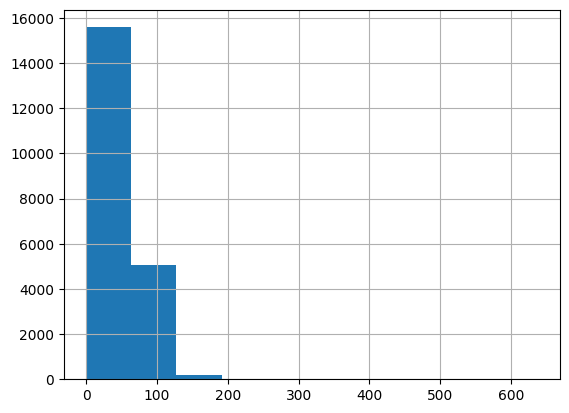

In [98]:
train_data['full_sq'].hist()

#### life_sq
Избавимся от аномалий по след. правилу:
- (life_sq > full_sq) -> аномалия

In [99]:
import pandas as pd
import numpy as np

def fill_life_sq_simple(df: pd.DataFrame,
                        ts_col: str = 'timestamp',
                        life_col: str = 'life_sq',
                        full_col: str = 'full_sq',
                        sub_area_col: str = 'sub_area',
                        product_col: str = 'product_type') -> pd.DataFrame:
    df = df.copy()
    
    df['year'] = pd.to_datetime(df[ts_col]).dt.year
    df['ratio'] = np.where(df['life_sq'].notna() & df['full_sq'].notna(),
                           df['life_sq'] / df['full_sq'],
                           np.nan)

    df['r_sub_year_prod'] = df.groupby(['sub_area', 'year', 'product_type'])['ratio'].transform('median')
    
    # df['r_sub_prod'] = df.groupby(['sub_area', 'product_type'])['ratio'].transform('median')
    # df['r_sub'] = df.groupby('sub_area')['ratio'].transform('median')
    # df['r_prod'] = df.groupby(product_col)['ratio'].transform('median')
    # df['r_year'] = df.groupby('year')['ratio'].transform('median')

    df['final_ratio'] = df['r_sub_year_prod'].fillna(df['r_sub_prod']) \
                                         .fillna(df['r_sub']) \
                                         .fillna(df['r_prod']) \
                                         .fillna(df['r_year'])

    # 5) fill life_sq where missing and full_sq present
    mask_fill_from_full = df['life_sq'].isna() & df['full_sq'].notna() & df['final_ratio'].notna()
    df.loc[mask_fill_from_full, 'life_sq'] = df.loc[mask_fill_from_full, 'full_sq'] * df.loc[mask_fill_from_full, 'final_ratio']

    if all(c in df.columns for c in [sub_area_col, 'year', product_col]):
        df['m_sub_year_prod'] = df.groupby([sub_area_col, 'year', product_col])[life_col].transform('median')
    else:
        df['m_sub_year_prod'] = np.nan

    if all(c in df.columns for c in [sub_area_col, product_col]):
        df['m_sub_prod'] = df.groupby([sub_area_col, product_col])[life_col].transform('median')
    else:
        df['m_sub_prod'] = np.nan

    if sub_area_col in df.columns:
        df['m_sub'] = df.groupby(sub_area_col)[life_col].transform('median')
    else:
        df['m_sub'] = np.nan

    df['m_year'] = df.groupby('year')[life_col].transform('median')

    df[life_col] = df[life_col].fillna(df['m_sub_year_prod']) \
                               .fillna(df['m_sub_prod']) \
                               .fillna(df['m_sub']) \
                               .fillna(df['m_year'])

    # final fallback: global median
    global_med = df[life_col].median(skipna=True)
    df[life_col] = df[life_col].fillna(global_med)

    # cleanup helper cols
    drop_cols = ['year','ratio','r_sub_year_prod','r_sub_prod','r_sub','r_prod','r_year',
                 'final_ratio','m_sub_year_prod','m_sub_prod','m_sub','m_year']
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

    return df

# Использование:
# train_data = fill_life_sq_simple(train_data)

In [100]:
train_data = train_data[train_data['life_sq'] <= train_data['full_sq']]
test_data = test_data[test_data['life_sq'] <= test_data['full_sq']]

In [101]:
train_data[['life_sq','full_sq']]

,life_sq,full_sq
7672,36.0,73
8056,11.0,11
8135,30.0,53
8144,37.0,41
8153,41.0,77
...,...,...
30464,51.0,56
30466,27.0,44
30467,59.0,86
30469,32.0,64


In [102]:
# nan_ratio = train_data.isna().mean()
# cols_to_drop = nan_ratio[nan_ratio >= 0.5].index.tolist()
# train_data.drop(columns=cols_to_drop, inplace=True)


# numeric_cols = train_data.select_dtypes(include=[np.number]).columns
# corr = train_data[numeric_cols].corr()['price_doc']
# to_drop = corr[abs(corr) < 0.09].index
# to_drop = [col for col in to_drop if col != 'price_doc']
# train_data_filtered = train_data.drop(columns=to_drop)
# train_data_filtered.shape

#### Работа с категориальными признаками

In [103]:
# train_data.corr()